# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # Subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The `extract_features`
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [6]:
from cs231n.features import *

num_color_bins = 20 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [7]:
# Use the validation set to tune the learning rate and regularization strength
import time
from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [1e5, 1e6, 1e7]

results = {}
best_val = -1
best_svm = None

tic = time.time()

for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg, num_iters=1500, verbose=False)
        y_train_pred = svm.predict(X_train_feats)
        y_val_pred = svm.predict(X_val_feats)
        acc_train = np.mean(y_train == y_train_pred)
        acc_val = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (acc_train, acc_val)
        if best_val < acc_val:
            best_val = acc_val
            best_svm = svm

toc = time.time()

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val
print 'That took %fs' % (toc - tic)

lr 1.000000e-09 reg 1.000000e+05 train accuracy: 0.092714 val accuracy: 0.091000
lr 1.000000e-09 reg 1.000000e+06 train accuracy: 0.101653 val accuracy: 0.104000
lr 1.000000e-09 reg 1.000000e+07 train accuracy: 0.419490 val accuracy: 0.419000
lr 1.000000e-08 reg 1.000000e+05 train accuracy: 0.098224 val accuracy: 0.100000
lr 1.000000e-08 reg 1.000000e+06 train accuracy: 0.420612 val accuracy: 0.428000
lr 1.000000e-08 reg 1.000000e+07 train accuracy: 0.415592 val accuracy: 0.412000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.419449 val accuracy: 0.421000
lr 1.000000e-07 reg 1.000000e+06 train accuracy: 0.414755 val accuracy: 0.428000
lr 1.000000e-07 reg 1.000000e+07 train accuracy: 0.322347 val accuracy: 0.328000
best validation accuracy achieved during cross-validation: 0.428000
That took 3.262000s


In [8]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print test_accuracy

0.422


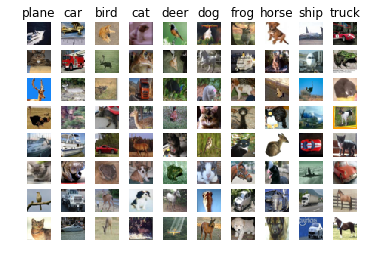

In [9]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

Not at all

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [10]:
print X_train_feats.shape

(49000L, 165L)


In [15]:
import time
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
num_classes = 10

def validate_params(hidden_size, num_iters, learning_rate, reg):
    net = TwoLayerNet(input_dim, hidden_size, num_classes)

    # Train the network
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=num_iters, batch_size=200,
                learning_rate=learning_rate, learning_rate_decay=0.95,
                reg=reg, verbose=True)

    # Predict on the validation set
    val_acc = (net.predict(X_val_feats) == y_val).mean()
    print 'Validation accuracy: ', val_acc
    return net, val_acc

best_net = None # store the best model into this 
best_val_acc = 0

input_size = 32 * 32 * 3
num_classes = 10

hidden_size_alt = [500]
reg_alt = [1e-5, 1e-4, 1e-3]
learning_rate_alt = [0.5]

for hidden_size in hidden_size_alt:
    for reg in reg_alt:
        for learning_rate in learning_rate_alt:
            tic = time.time()
            net, val_acc = validate_params(hidden_size, 1000, learning_rate, reg)
            if best_val_acc < val_acc:
                best_net = net
                best_val_acc = val_acc
                best_params = [hidden_size, reg, learning_rate]
            toc = time.time()
            print 'That took %fs' % (toc - tic)

print 'Best validation accuracy: ', best_val_acc

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.542071
iteration 200 / 1000: loss 1.371668
iteration 300 / 1000: loss 1.291932
iteration 400 / 1000: loss 1.171316
iteration 500 / 1000: loss 1.246157
iteration 600 / 1000: loss 1.248320
iteration 700 / 1000: loss 1.156873
iteration 800 / 1000: loss 1.086151
iteration 900 / 1000: loss 1.099648
Validation accuracy:  0.58
That took 3.579000s
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.500411
iteration 200 / 1000: loss 1.387993
iteration 300 / 1000: loss 1.249004
iteration 400 / 1000: loss 1.344029
iteration 500 / 1000: loss 1.098392
iteration 600 / 1000: loss 1.093226
iteration 700 / 1000: loss 1.184747
iteration 800 / 1000: loss 1.108694
iteration 900 / 1000: loss 1.062978
Validation accuracy:  0.592
That took 3.602000s
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.495006
iteration 200 / 1000: loss 1.299301
iteration 300 / 1000: loss 1.273642
iteration 400 / 1000: loss 1.308705
iteration 5

In [16]:
print best_params


[500, 0.0001, 0.5]


In [17]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print test_acc

0.561


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!